In [28]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import lime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

import lime.lime_tabular

In [3]:
df = pd.read_csv("hcvdatUCI.csv",header = 0)

In [4]:
df.head() # Need to change the label classes


,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [5]:
df = df.dropna()
df.shape

(589, 14)

In [6]:
df = df.replace({"1=Hepatitis":1,"2=Fibrosis":2,"3=Cirrhosis":3})
df = df.drop(columns = ['Unnamed: 0','Age','Sex'])
df.drop(df.loc[df['Category']=="0s=suspect Blood Donor"].index, inplace=True) 
df.drop(df.loc[df['Category']=="0=Blood Donor"].index,inplace=True)
# inplace = T returns dataframe without removed column label
# replacing suspect donors and healthy donors, just studying disease population
df = df.astype('float')
# Replacing category


In [7]:
df.head # Final dataset I will be working on


<bound method NDFrame.head of      Category   ALB    ALP   ALT    AST    BIL    CHE  CHOL    CREA    GGT  \
542       1.0  47.0   19.1  38.9  164.2   17.0   7.09  3.20    79.3   90.4   
543       1.0  42.0   38.2  63.3  187.7   14.0   6.00  4.28    66.9   40.2   
544       1.0  45.0   27.5  10.5   37.8   10.0   8.77  3.20    55.2   35.9   
547       1.0  45.0   34.6  44.3   96.2   16.0  10.11  6.28    81.2   48.1   
548       1.0  41.0   34.4  12.1   60.9    6.0  13.80  5.48    45.4   33.1   
549       1.0  46.0   36.7   7.4   31.6    9.0   9.71  5.37    82.3   34.4   
550       1.0  47.0   37.9  13.3   48.4    8.0  10.30  4.14    69.2   68.2   
551       1.0  44.0   32.9   9.4   32.0   14.0  11.42  5.73    68.6   40.6   
552       1.0  41.0   20.6  15.2   53.5   24.0  10.23  4.89    81.8   57.9   
553       1.0  42.0   39.6  26.5   77.6   42.0   9.67  9.67    57.7  143.4   
554       1.0  49.0   27.3  40.2   31.1   13.0   8.91  4.07    81.5   27.6   
555       1.0  48.0   59.5  11.6  

In [8]:
# Subsetting out input and labels
X_ori = df.drop(columns = ['Category'])
X = (X_ori- X_ori.mean())/X_ori.std() # Normalizing
y = df['Category']


[[Text(0, 0, 'Hepatitis'), Text(0, 1, 'Fibrosis'), Text(0, 2, 'Cirrhosis')]]

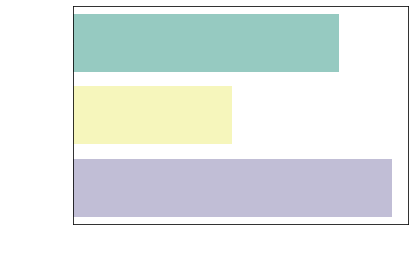

In [9]:
# Preliminary data exploration for distribution
counts = sb.countplot(y='Category',data=df,palette ='Set3')
counts.xaxis.label.set_color('white')
counts.tick_params(axis='x', colors='white')
counts.yaxis.label.set_color('white')
counts.tick_params(axis='y', colors='white')

y_labels = ("Hepatitis", "Fibrosis","Cirrhosis")
counts.set(yticklabels=y_labels)

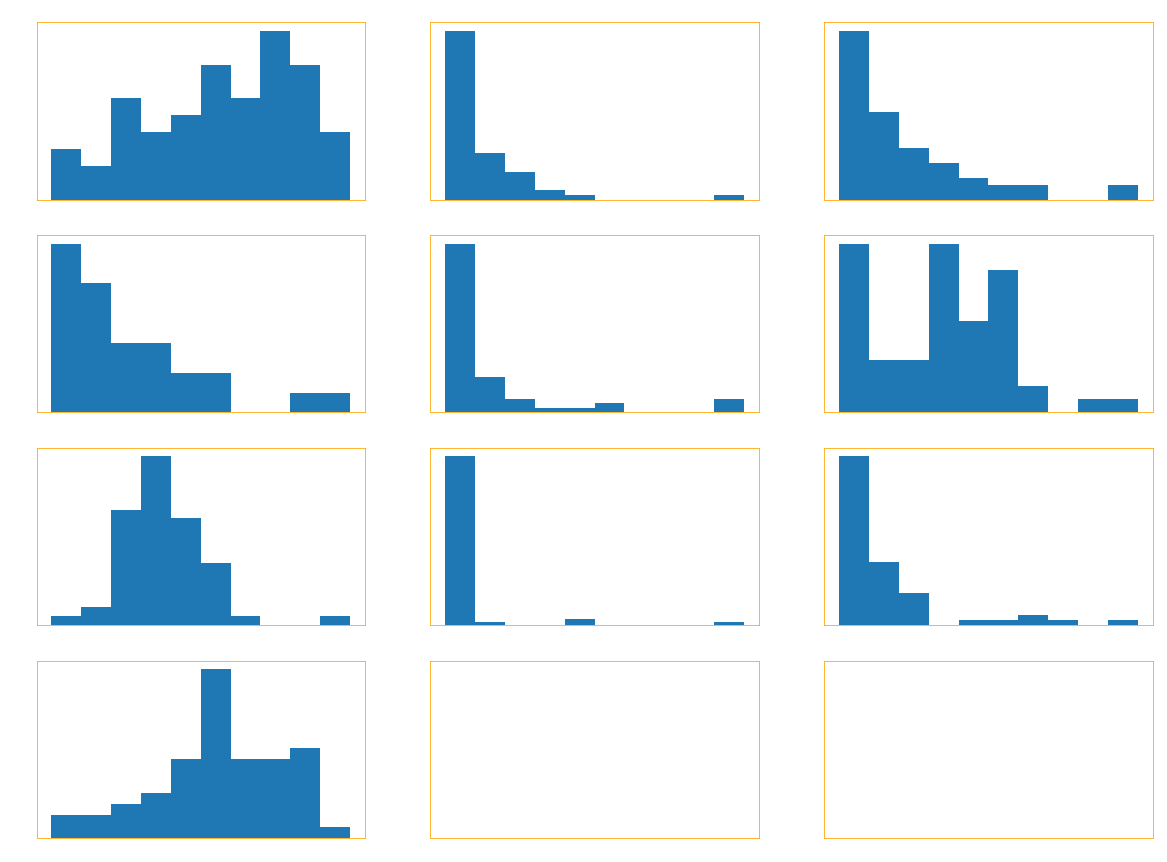

In [10]:
with plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'white', 
                     'ytick.color':'white','axes.titlecolor':'white'}):

    fig, axes = plt.subplots(4,3, figsize=(20,15)) #Initialize subplot (11 features)

    for i in range(0,1):
        for j in range(0,3):
            axes[i,j].hist(df.iloc[:,1+i+j])
            axes[i,j].set_title(df.iloc[:,1+i+j].name)

    for i in range(1,2):
        for j in range(0,3):
            axes[i,j].hist(df.iloc[:,3+i+j])
            axes[i,j].set_title(df.iloc[:,3+i+j].name)
            
    for i in range(2,3):
        for j in range(0,3):
            axes[i,j].hist(df.iloc[:,5+i+j])
            axes[i,j].set_title(df.iloc[:,5+i+j].name)
    
    axes[3,0].hist(df.iloc[:,10])
    axes[3,0].set_title(df.iloc[:,10].name)

    # Skewed distributions indicate better predictors of class
    # Indicates that 'something' is causing skewedness, which is possibly explained by disease

In [11]:
# Splitting my data into testing and cross validation sets
X_traincv, X_test, y_traincv, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# random_state sets a fixed parameter that can be recalled for the same shuffle order

kf = KFold(n_splits = 4, random_state = 30, shuffle = True)
# Setting parameters for Kfold

for train_index, test_index in kf.split(X_traincv):
    X_train, X_cv = X_traincv.iloc[train_index], X_traincv.iloc[test_index]
    y_train, y_cv = y_traincv.iloc[train_index], y_traincv.iloc[test_index]

    # Kfold provide the indices for training and testing set by splitting into
    # k consecutive folds
    # Each fold is used as a validation set once, the remaining k-1 fold forms training set

Minimum error:- 0.36363636363636365 at K = 5


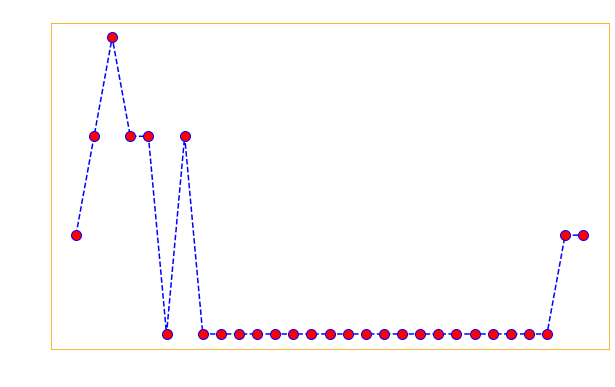

In [22]:
error_rate = []
for i in range(1,30):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_cv)
 error_rate.append(np.mean(pred_i != y_cv))

with plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'white', 
                     'ytick.color':'white','axes.titlecolor':'white', 'axes.labelcolor':'white'}):
    
    plt.figure(figsize=(10,6))
    plt.plot(range(1,30),error_rate,color='blue', linestyle='dashed', 
             marker='o',markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [18]:
plt.rcParams # used to check label options


RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [24]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train,y_train) # Fit Model with training data

y_pred = knn.predict(X_test) # Test

print("Accuracy: ", metrics.accuracy_score(y_test,y_pred))
# ~60% accuracy

Accuracy:  0.5833333333333334


In [ ]:
# LIME model explanation: TBC